In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModel, AutoTokenizer
import torch
import time

C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from lrp import lrp_engine, checkpoint_hook

In [4]:
model_name = "zhihan1996/DNABERT-2-117M"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

C:\Users\Kevin\.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\7bce263b15377fc15361f52cfab88f8b586abda0\bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(4096, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertUnpadAttention(
          (self): BertUnpadSelfAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (mlp): BertGatedLinearUnitMLP(
          (gated_layers): Linear(in_features=768, out_features=6144, bias=False)
          (act): GELU(approximate='none')
          (wo): L

In [6]:
for layer_module in model.encoder.layer:
    layer_module.attention.self.register_forward_hook(checkpoint_hook)

In [11]:
dna = "CTGAAATTTTTTTCGTTTCGCCACCAAGAAAGGCTAATTGAATACAGTTCAAGAGGTTGATATAGCTAAGTGGGCATGAAGGTTATGAATTGTAATTGGAGGTGCGGCAAGTGTGCAAGACGGGTAAAGGAGAGTATAGAACGATGTCTGCTAAAGTTCCATCTAACGCCACGTTTAAGAACAAGGAAAAACCTCAAGAGGTTCGCAAAGCCAACATCATCGCTGCACGTTCTGTTGCAGATGCCATCCGTACTTCATTGGGTCCCAAGGGTATGGACAAGATGATTAAGACATCTCGTGGAGAAATCATCATCTCTAATGATGGCCACACCATTCTAAAACAGATGGCCATTCTGCATCCGGTGGCCAGAATGCTAGTAGAGGTTTCTGCCGCGCAGGACTCGGAAGCCGGTGATGGTACCACTTCTGTGGTGATCTTGACCGGAGCTCTATTGGGTGCTGCTGAGAGGCTGTTAAACAAGGGCATCCATCCAACCATC"
inputs = tokenizer(dna, return_tensors = 'pt')["input_ids"]
hidden_states : torch.Tensor = model(inputs.to(device), requires_grad=True)[0] # [1, sequence_length, 768]

In [12]:
checkpoint_vals, in_adj_list, out_adj_list, visited1 = lrp_engine(hidden_states.half())

took 1.5655255317687988 seconds


In [13]:
from add_backward_promise import AddBackwardPromise
visited = sorted(list(visited1), key=lambda x: x._sequence_nr())
visited_map = { str(node) : node for node in visited }
promises = AddBackwardPromise.all_promises

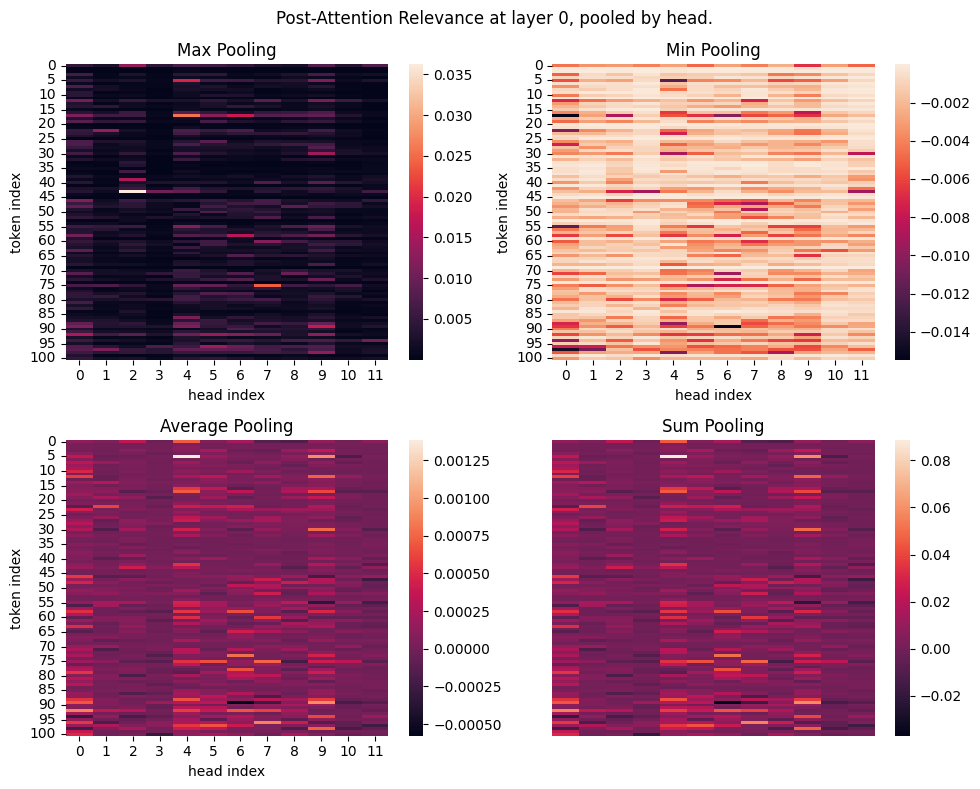

In [14]:
# Visualizing relevance of attention mechanism
import seaborn as sns
import matplotlib.pyplot as plt

# Set this to which layer you want to see
layer_ind = 0

# Use pooling with kernel size and stride set to d_head = d_model / num_heads = 64 (for DNABERT2)
max_pool = torch.nn.MaxPool1d(kernel_size=64, stride=64)
min_pool = lambda x: -max_pool(-x)
avg_pool = torch.nn.AvgPool1d(kernel_size=64, stride=64)
sum_pool = torch.nn.LPPool1d(kernel_size=64, stride=64, norm_type=1)

pools = {
    "Max Pooling": max_pool,
    "Min Pooling": min_pool,
    "Average Pooling": avg_pool,
    "Sum Pooling": sum_pool,
}

fig, axs = plt.subplots((len(pools) + 1) // 2, 2, figsize=(10,8))
fig.subplots_adjust(top=1.0)

for i, (pool_name, pool_layer) in enumerate(list(pools.items())):
    # Make a heatmap for each type of pooling
    checkpoint_output = pool_layer(torch.unsqueeze(checkpoint_vals[layer_ind], 0))
    lrp_shape = checkpoint_output.shape
    sns.heatmap(checkpoint_output.view((lrp_shape[-2], lrp_shape[-1])).cpu(), ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(pool_name)
    axs[i // 2, i % 2].set_xlabel("head index")
    axs[i // 2, i % 2].set_ylabel("token index")

# Remove overflow subplot
if i < ((len(pools) + 1) // 2) * 2:
    axs[i // 2, 1].set_axis_off()
fig.suptitle(f"Post-Attention Relevance at layer {layer_ind}, pooled by head.")
fig.tight_layout()

plt.show()

In [11]:
# For debugging relevance paths

# import networkx as nx
# import matplotlib.pyplot as plt

# node_to_ind = { node : i for (i, node) in enumerate(nodes) }
# def create_graph(nodes, in_adj_list, weights, alpha = 0.5):    
#     G = nx.DiGraph()
#     G.add_nodes_from(range(len(nodes)))

#     print(node_to_ind[start], node_to_ind[end]) # Global vars, set somewhere

#     for node, in_nodes in list(in_adj_list.items()):
#         if node not in nodes:
#             continue
#         for in_node, in_weight in zip(in_nodes, input_tracker[node]):
#             if in_node not in nodes:
#                 continue
#             if isinstance(in_weight, AddBackwardPromise):
#                 if in_weight.complete:
#                     in_weight = in_weight.rin.sum()
#                 else:
#                     continue
#             elif isinstance(in_weight, torch.Tensor):
#                 in_weight = in_weight.sum()
#             G.add_edge(node_to_ind[in_node], node_to_ind[node], weight=float(in_weight))
#     return G

# def display_graph(G):
#     pos = nx.circular_layout(G)  
#     weight_labels = nx.get_edge_attributes(G, 'weight')
#     plt.figure(figsize=(50,50))
#     nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=100)
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=weight_labels)  
#     plt.show()

# G = create_graph(nodes, in_adj_list, input_tracker)

# print([ x for x in dir(nx) if x.endswith("layout") ])
# display_graph(G)
# print(nx.get_edge_attributes(G, 'weight'))


In [12]:
# Check that promises maintain conservation property
complete = list(filter(lambda p: p.complete, promises))
for p in complete:
    rout = p.promise["rout"].sum()
    rin = p.promise["rins"][0].sum() + p.promise["rins"][1].sum()
    if (rout - rin) / rout > 0.00001:
        print(rout, rin)
        

In [13]:
# Checking conservation holds across the entire propagation
# The frontier includes:
# a) true leaf nodes (no children)
# b) nodes which received inputs but were never traversed due to computation ending early

frontier = [ node 
            for node, out_nodes in list(out_adj_list.items())
            if len(out_nodes) == 0
           ]

frontier += [ node for node in stack if input_tracker[node] ]

frontier = list(set(frontier))

In [14]:
# Tally the total relevance at the frontier
total_frontier_in = 0.0
for node in frontier:
    total_in = 0.0
    for input_ in input_tracker[node]:
        if isinstance(input_, AddBackwardPromise):
            if input_.complete:
                total_in += input_.rin.sum()
            else:
                continue
        elif isinstance(input_, torch.Tensor):
            total_in += input_.sum()
    total_frontier_in += total_in
print(total_frontier_in)

tensor(17.0376)


In [85]:
list(enumerate(visited))

[(0, <NativeLayerNormBackward0 at 0x21cd31ebee0>),
 (1, <ViewBackward0 at 0x21cd31eb790>),
 (2, <torch.autograd.function.IndexFirstAxisBackward at 0x21b051738a0>),
 (3, <torch.autograd.function.LRPCheckpointBackward at 0x21cd31679b0>),
 (4, <util.MmBackward0 at 0x21cced12050>),
 (5, <util.AddBackward0 at 0x21cced13950>),
 (6, <AddBackward0 at 0x21cd31e8fa0>),
 (7, <NativeLayerNormBackward0 at 0x21cd31eb3d0>),
 (8, <MmBackward0 at 0x21cd31ef250>),
 (9, <SliceBackward0 at 0x21cd31ef010>),
 (10, <SliceBackward0 at 0x21cd31ebfa0>),
 (11, <SliceBackward0 at 0x21cd31ebf10>),
 (12, <SliceBackward0 at 0x21cd31eb9d0>),
 (13, <GeluBackward0 at 0x21cd31eb8b0>),
 (14, <MulBackward0 at 0x21cd31e8e80>),
 (15, <util.AddBackward0 at 0x21cced16050>),
 (16, <util.MmBackward0 at 0x21cced16210>),
 (17, <AddBackward0 at 0x21cd31e8880>),
 (18, <NativeLayerNormBackward0 at 0x21cd31e89d0>),
 (19, <util.AddBackward0 at 0x21ccc62abd0>),
 (20, <util.MmBackward0 at 0x21ccc62bd10>),
 (21, <torch.autograd.function.